# 2. Quickstart: Running a single Schwarzschild model

By the end of the notebook, you will have run a Schwarzschild model. This will involve:
1. understanding the configuration file
2. executing commands to create and run a Schwarzschild model
3. plotting some output for this model

To get started, let's import DYNAMITE and print the version and installation path:

In [1]:
import dynamite as dyn

print('DYNAMITE')
print('    version', dyn.__version__)
#print('    installed at ', dyn.__path__) # Uncomment to print the complete DYNAMITE installation path

DYNAMITE
    version 4.0.0


## Input files

You should be in the directory ```docs/tutorial_notebooks```. To prepare the input data files, you should first run the CALIFA section of the previous tutorial "Data Preparation for Gauss Hermite kinematics" (``1_data_prep_for_gauss_hermite.ipynb``). 

If this is the first time you run this tutorial, this directory should have the following structure:

```
tutorial_notebooks
    |- ...
    |- NGC6278_input
        |- dynamite_input
            |- aperture.dat
            |- bins.dat
            |- gauss_hermite_kins.ecvs
            |- kinmaps.pdf
            |- mge.ecsv
            |- pafit.pdf
        |- NGC6278.V1200.rscube_INDOUSv2_SN20_stellar_kin.fits
    |- NGC6278_config.yaml
    |- NGC6278_config_single.yaml
    |- *.ipynb
    |- ...
```

The input data files needed to run DYNAMITE are:

- ``mge.ecvs`` - the Multi Gaussian Expansion (MGE) describing the stellar surface density of the galaxy
- ``gauss_hermite_kins.ecsv`` - the kinematics extracted for this galaxy
- ``aperture.dat`` and ``bins.dat`` - information about the spatial apertures/bins used for kinematic extraction

The MGE and kinematics files must be in the form of [Astropy ECSV files](https://docs.astropy.org/en/stable/api/astropy.io.ascii.Ecsv.html). This is a convenient and flexible file format, so we use it whenever possible for storing our input and output data.

We have provided example input data file for a specific galaxy (NGC 6278), and in the directory `NGC6278_input` you can also see some diagnostic plots. A very basic set of instructions to generate your own input data is as follows:

- fit a MGE to a photometric image, e.g. using [mge](http://www-astro.physics.ox.ac.uk/~mxc/software/#mge)
- create a Voronoi binning of your IFU datacube, e.g. using [e.g. vorbin](http://www-astro.physics.ox.ac.uk/~mxc/software/#binning)
- extract kinematics from the binned datacube, e.g. using [e.g. PPXF](http://www-astro.physics.ox.ac.uk/~mxc/software/#ppxf)
- make the `aperture.dat` and `bins.dat` files; an example script to do this is ``generate_input_califa.py``, which can be found [here](https://github.com/dynamics-of-stellar-systems/triaxschwarz/tree/sabine/schwpy/data_prepare)

## Configuration file

The configuration file controls all the settings that you may wish to vary when running your Schwarschild models. For example, in the configuration file you can specify:

- the components of the gravitational potential
- the parameters describing the potential, the parameter ranges, etc.
- what type of kinematic data you are providing, e.g.
    - discrete vs continuous,
    - Gauss-Hermite vs Histograms
- the location of the input and output files
- the number of models you want to run

This list of options is incomplete - for a more detailed description of the configuration file, see the documentation.

The configuration file for this tutorial is
```
NGC6278_config_single.yaml
```
Open this file in a text editor, alongside this notebook, to see how it is organised. The file is in `yaml` format. The basic structure of a yaml file are pairs of keys and values
```
key : value
```
which can be organised into hierarchical levels separated by tabs
```
main_key:
    sub_key1 : value1
    sub_key2 : value2
```
Comments begin with a ``#``. Values can be any type of variable (integers, floats, strings, booleans, etc.).

To read the congfiguration file we can use the following command, which creates a configuration object (called `c` here):

In [2]:
fname = 'NGC6278_config_single.yaml'
c = dyn.config_reader.Configuration(fname, reset_logging=True)

[INFO] 19:41:43 - dynamite.config_reader.Configuration - Config file NGC6278_config_single.yaml read.
[INFO] 19:41:43 - dynamite.config_reader.Configuration - io_settings...
[INFO] 19:41:43 - dynamite.config_reader.Configuration - Output directory tree: NGC6278_output/.
[INFO] 19:41:43 - dynamite.config_reader.Configuration - system_attributes...
[INFO] 19:41:43 - dynamite.config_reader.Configuration - model_components...
[INFO] 19:41:43 - dynamite.config_reader.Configuration - system_parameters...
[INFO] 19:41:43 - dynamite.config_reader.Configuration - orblib_settings...
[INFO] 19:41:43 - dynamite.config_reader.Configuration - weight_solver_settings...
[INFO] 19:41:43 - dynamite.config_reader.Configuration - Will attempt to recover partially run models.
[INFO] 19:41:43 - dynamite.config_reader.Configuration - parameter_space_settings...
[INFO] 19:41:43 - dynamite.config_reader.Configuration - multiprocessing_settings...
[INFO] 19:41:43 - dynamite.config_reader.Configuration - ... usi

When making this object, some output is printed, telling you whether any previous models have been found. If you are running this tutorial for the first time, no models will be found and an empty table will be created at ``AllModels.table``. This table holds information about all the models which have been run so far.

Remark: if you run this tutorial again and wish to start from empty output, you can either manually delete the output directory tree (`NGC6278_output`) or add the parameter `reset_existing_output=True` to the configuration object constructor: `c = dyn.config_reader.Configuration(fname, reset_logging=True, reset_existing_output=True)`.

The configuration object ``c`` is structured in a similar way to the configuration file itself. For example, the configuration file is split into two sections. The top section defines aspects the physical system we wish to model - e.g. the globular cluster, galaxy or galaxy cluster - while the second section contains all other settings we need for running a model - e.g. settings about the orbit integration and input/output options. The two sections are stored in the ``system`` and ``settings`` attributes of the configuration object, respectively.

In [3]:
print(type(c.system))
print(type(c.settings))

<class 'dynamite.physical_system.System'>
<class 'dynamite.config_reader.Settings'>


The physical system is comprised of components, which are stored in a list ``c.system.cmp_list``.

In [4]:
print(f'cmp_list is a {type(c.system.cmp_list)}')
print(f'cmp_list has length {len(c.system.cmp_list)}')

cmp_list is a <class 'list'>
cmp_list has length 3


Let's print some information about the components:

In [5]:
for i in range(len(c.system.cmp_list)):
    
    print(f'Information about component {i}:')

    # Extract component i from the component list
    component = c.system.cmp_list[i]

    # Print the name of the component
    print(f'   name =  {component.name}')

    # Print a list of the names of the parameters of this component
    parameters = component.parameters
    parameter_names = [par0.name for par0 in parameters]
    string = '   has parameters : '
    for name in parameter_names:
        string += f'{name} , '
    print(string)

    # Print the type of this component
    print(f'   type =  {type(component)}')

    # Does it contribute to the potential?
    print(f'   contributes to the potential? -  {component.contributes_to_potential}')

Information about component 0:
   name =  bh
   has parameters : m-bh , a-bh , 
   type =  <class 'dynamite.physical_system.Plummer'>
   contributes to the potential? -  True
Information about component 1:
   name =  dh
   has parameters : c-dh , f-dh , 
   type =  <class 'dynamite.physical_system.NFW'>
   contributes to the potential? -  True
Information about component 2:
   name =  stars
   has parameters : q-stars , p-stars , u-stars , 
   type =  <class 'dynamite.physical_system.TriaxialVisibleComponent'>
   contributes to the potential? -  True


Each component has a name, some parameters, and a type. **Currently, DYNAMITE only supports this exact combination of component types**:

- one ``Plummer`` component representing the black hole
- one component representing the dark halo (DYNAMITE supports ``NFW`` and a number of additional dark halos, see API documentation)
- one ``TriaxialVisibleComponent`` representing the stellar body of the galaxy

In the future, we plan to support other components, and more flexible combinations of components.

For the stars - i.e. component 2 above - we must provide some input data files. The location of these files is specified in the configuration file, at
```
settings -> io_settings -> input_directory
```
and takes the value:

In [6]:
c.settings.io_settings['input_directory']

'NGC6278_input/dynamite_input/'

The names of the necessary input files are also specified in the configuration file, at the following locations:
```
system_components -> stars -> mge_pot
system_components -> stars -> mge_lum
system_components -> stars -> kinematics -> <kinematics name> --> datafile
system_components -> stars -> kinematics -> <kinematics name> --> aperturefile
system_components -> stars -> kinematics -> <kinematics name> --> binfile
```
which take as values the relevant filenames. You are free to give these files whatever name you like, as long as it is specified in the configuration file.

Let's have a look at the MGE:

In [7]:
c.system.cmp_list[2].mge_pot, c.system.cmp_list[2].mge_lum

(MGE({'name': None, 'datafile': 'mge.ecsv', 'input_directory': 'NGC6278_input/dynamite_input/', 'data': <Table length=6>
    I      sigma      q    PA_twist
 float64  float64  float64 float64 
 -------- -------- ------- --------
 26819.14  0.49416 0.89541      0.0
  2456.39  2.04299 0.79093      0.0
    456.8  2.44313  0.9999      0.0
   645.49   6.5305 0.55097      0.0
    14.73 17.41488  0.9999      0.0
   123.85 21.84711 0.55097      0.0, 'logger': <Logger dynamite.mges.MGE (DEBUG)>}),
 MGE({'name': None, 'datafile': 'mge.ecsv', 'input_directory': 'NGC6278_input/dynamite_input/', 'data': <Table length=6>
    I      sigma      q    PA_twist
 float64  float64  float64 float64 
 -------- -------- ------- --------
 26819.14  0.49416 0.89541      0.0
  2456.39  2.04299 0.79093      0.0
    456.8  2.44313  0.9999      0.0
   645.49   6.5305 0.55097      0.0
    14.73 17.41488  0.9999      0.0
   123.85 21.84711 0.55097      0.0, 'logger': <Logger dynamite.mges.MGE (DEBUG)>}))

The kinematic data are stored here:

In [8]:
type(c.system.cmp_list[2].kinematic_data)

list

Note that this object has type ``list``. This is because a single component can have multiple different sets of kinematic data. In this example, the first (and only) entry in the list is

In [9]:
type(c.system.cmp_list[2].kinematic_data[0])

dynamite.kinematics.GaussHermite

We see that this kinematics object has type ``GaussHermite``. This was also specified in the configuration file, under
```
system_components -> stars -> kinematics --> kinset1 --> type
```

In addition to ``GaussHermite``, DYNAMITE also supports ``BayesLOSVD`` kinematics (see documentation).

The kinemtic data itself can be accessed as follows:

In [10]:
c.system.cmp_list[2].kinematic_data[0].data

vbin_id,v,dv,sigma,dsigma,h3,dh3,h4,dh4
int64,float64,float64,float64,float64,float64,float64,float64,float64
1,-44.7518,2.0988,211.7829,1.9654,0.0,0.005,0.0,0.005
2,-69.2798,2.3608,188.883,2.1766,0.0,0.005,0.0,0.005
3,-70.8007,3.9338,177.095,3.7142,0.0,0.005,0.0,0.005
4,-47.9191,3.4617,184.1865,3.0684,0.0,0.005,0.0,0.005
5,-30.5932,2.386,208.2472,2.2207,0.0,0.005,0.0,0.005
6,-76.5504,5.5494,162.3144,4.572,0.0,0.005,0.0,0.005
7,-49.8285,4.4211,174.0705,3.6461,0.0,0.005,0.0,0.005
8,-35.7514,3.5335,180.28,3.3672,0.0,0.005,0.0,0.005
9,-75.4144,3.5041,139.9438,3.9235,0.0,0.005,0.0,0.005


## Creating a Schwarzschild model

The next step will be to create a model, i.e. a `dyn.model.Model` object for a particular `parset`. This is a particular set of values for each of the parameters of the model. In the configuration file, every parameter has a been given a `value`. We can extract and inspect a parameter set specified by these values as follows:

In [11]:
parset = c.parspace.get_parset()
print(parset)

       m-bh        a-bh c-dh f-dh q-stars p-stars u-stars  ml
----------------- ----- ---- ---- ------- ------- ------- ---
158489.3192461114 0.001  8.0 10.0    0.54    0.99  0.9999 5.0


Note that parameters which have been specified as logarithmic, i.e. those configured as 
```
parameters -> XXX -> logarithmic : True
```
are exponentiated in this table, while their value is logarithmic in the configuration file. 

More details can be found in the documentation and in the tutorial "Parameter Space" (`5_parameter_space.ipynb`).

DYNAMITE uses the `ModelIterator` object to run models. In this case, only one model will be run because the configuration file fixes all parameters to their respective values (`fixed: True`). In the following tutorial "Model Iterations and Plots" (`3_model_iterations_and_plots.ipynb`) we will see how to run a suite of models. To better understand what the model iterator does, let's read the internal documentation (i.e. the docstring) for the class:
```
class ModelIterator(object):
    """Iterator for models

    Creating this ``ModelIterator`` object will (i) generate parameters sets,
    (ii) run models for those parameters, (iii) check stopping criteria, and
    iterate this procedure till a stopping criterion is met. This is implemented
    by creating a ``ModelInnerIterator`` object whose ``run_iteration`` method
    is called a number of times.

    Parameters
    ----------
    config : a ``dyn.config_reader.Configuration`` object
    model_kwargs : dict
        other kewyord argument required for this model
    do_dummy_run : Bool
        whether this is a dummy run - if so, dummy_chi2_funciton is executed
        instead of the model (for testing!)
    dummy_chi2_function : function
        a function of model parameters to be executed instead of the real model
    plots : bool
        whether or not to make plots

    """
    def __init__(self,
                 config=None,
                 model_kwargs={},
                 do_dummy_run=None,
                 dummy_chi2_function=None,
                 plots=True):
```

All we need to do is pass the configuration object `c` when we instantiate the `ModelIterator`. The following step will take a few minutes (we will not need the `ModelIterator` object itself, so we discard the return value):

In [12]:
_ = dyn.model_iterator.ModelIterator(config=c)

[INFO] 19:41:43 - dynamite.model_iterator.ModelIterator - SpecificModels: iteration 4
[INFO] 19:41:43 - dynamite.parameter_space.SpecificModels - Found ONE individual model.
[INFO] 19:41:43 - dynamite.parameter_space.SpecificModels - SpecificModels added 1 new model(s) out of 1
[INFO] 19:41:43 - dynamite.model_iterator.ModelInnerIterator - ... running model 1 out of 1
[INFO] 19:41:43 - dynamite.orblib.LegacyOrbitLibrary - Calculating initial conditions
[INFO] 19:42:28 - dynamite.orblib.LegacyOrbitLibrary - ...done - cmd_orb_start exit code 0. Logfile: NGC6278_output/models/orblib_004_000/datfil/orbstart.log.
[INFO] 19:42:28 - dynamite.orblib.LegacyOrbitLibrary - Integrating orbit library tube and box orbits
[INFO] 19:42:36 - dynamite.orblib.LegacyOrbitLibrary - ...done - cmd_tube_box_orbs exit code 0. Logfiles: NGC6278_output/models/orblib_004_000/datfil/orblib.log, NGC6278_output/models/orblib_004_000/datfil/orblibbox.log, NGC6278_output/models/orblib_004_000/datfil/triaxmass.log, NGC

[INFO] 19:42:43 - dynamite.weight_solvers.LegacyWeightSolver - Using WeightSolver: LegacyWeightSolver
[INFO] 19:42:43 - dynamite.weight_solvers.LegacyWeightSolver - Reading NNLS solution from existing legacy output and converting to weights file.
[WARNING] 19:42:43 - dynamite.model.Model - ACTION REQUIRED, PLEASE CHECK: The current config file NGC6278_config_single.yaml differs from the config file NGC6278_output/models/orblib_000_000/ml06.00/NGC6278_config.yaml backup in the model directory. Diff output:
--- NGC6278_config_single.yaml
+++ NGC6278_output/models/orblib_000_000/ml06.00/NGC6278_config.yaml
@@ -24,7 +24,7 @@
                     step: 1.
                     minstep: 0.
                 fixed: True
-                value: 5.2
+                value: 5.0
                 logarithmic: True
                 LaTeX: "$M_{BH}$"
             a:
@@ -53,7 +53,7 @@
                     step: 0.5
                     minstep: 0.1
                 logarithmic: True
-                fi

A lot happened here: when run for the first time, the particular `parset` is new, so DYNAMITE creates a new entry in AllModels.table and assigns a model directory that will hold the results. The next step is to calculate the orbit library and then DYNAMITE finds out which orbits are useful for reproducing the observations. This is an Non-Negative Least Squares (NNLS) optimization problem resulting in a certain chi-squared value. Let's first have a look at the all models table:

In [13]:
c.all_models.table

m-bh,a-bh,c-dh,f-dh,q-stars,p-stars,u-stars,ml,chi2,kinchi2,kinmapchi2,time_modified,orblib_done,weights_done,all_done,which_iter,directory
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str256,bool,bool,bool,int64,str256
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,5.0,33649.39086884704,15917.066860828405,21314.247848107774,2023-10-26T16:29:56.000,True,True,True,0,orblib_000_000/ml05.00/
100000.0,0.001,8.0,3.1622776601683795,0.54,0.99,0.9999,5.0,30991.11762762379,17598.730851933888,22815.05093199939,2023-10-26T16:29:56.000,True,True,True,1,orblib_001_000/ml05.00/
100000.0,0.001,8.0,31.622776601683793,0.54,0.99,0.9999,5.0,40173.175744770124,16959.42790658713,22206.509342121193,2023-10-26T16:29:56.000,True,True,True,1,orblib_001_001/ml05.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,1.0,497022.221964989,362170.4757700949,189457.78696958243,2023-10-26T16:29:59.000,True,True,True,1,orblib_000_000/ml01.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,9.0,54888.860024039765,36551.18477693207,75141.63217246106,2023-10-26T16:29:59.000,True,True,True,1,orblib_000_000/ml09.00/
100000.0,0.001,8.0,5.623413251903491,0.54,0.99,0.9999,5.0,36730.03922229585,16672.12206429719,20550.53558278929,2023-10-26T16:31:02.000,True,True,True,2,orblib_002_000/ml05.00/
100000.0,0.001,8.0,17.78279410038923,0.54,0.99,0.9999,5.0,52679.2856566222,16544.940123191423,21818.352798117987,2023-10-26T16:31:02.000,True,True,True,2,orblib_002_001/ml05.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,3.0,77417.30767015449,53526.44612487139,48837.247282250304,2023-10-26T16:31:05.000,True,True,True,2,orblib_000_000/ml03.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,7.0,35168.23021192741,18463.68353309457,36806.02968568541,2023-10-26T16:31:05.000,True,True,True,2,orblib_000_000/ml07.00/


This table is stored in the `all_models_file` in the `output_directory` as defined in the configuration file:

In [14]:
c.settings.io_settings['output_directory'], c.settings.io_settings['all_models_file']

('NGC6278_output/', 'all_models.ecsv')

In the output directory we find the `AllModels.table` and a `models/` subfolder (in our case, `NGC6278_output/all_models.ecsv` and `NGC6278_output/models/`, respectively), which hold the model parameters, status, and results in the so-called model directories as stated in the `AllModels.table`.

Let's look into how to access information about specific models in the `AllModels.table` (see the Model API documentation for more information). We start with instantiating a `dyn.model.Model` object from the table (here we use the only model in the table, which has index 0):

In [15]:
model = c.all_models.get_model_from_row(0)

[WARNING] 19:42:54 - dynamite.model.Model - ACTION REQUIRED, PLEASE CHECK: The current config file NGC6278_config_single.yaml differs from the config file NGC6278_output/models/orblib_000_000/ml05.00/NGC6278_config.yaml backup in the model directory. Diff output:
--- NGC6278_config_single.yaml
+++ NGC6278_output/models/orblib_000_000/ml05.00/NGC6278_config.yaml
@@ -24,7 +24,7 @@
                     step: 1.
                     minstep: 0.
                 fixed: True
-                value: 5.2
+                value: 5.0
                 logarithmic: True
                 LaTeX: "$M_{BH}$"
             a:
@@ -53,7 +53,7 @@
                     step: 0.5
                     minstep: 0.1
                 logarithmic: True
-                fixed: True
+                fixed: False
                 value: 1.0
                 LaTeX: "$M_{200}/M_*$"
         type: NFW
@@ -109,7 +109,7 @@
             hi: 9.
             step: 4.0
             minstep: 0.5
-        fixed: True
+        f

In [16]:
model.parset # Verify the model's parameter set

m-bh,a-bh,c-dh,f-dh,q-stars,p-stars,u-stars,ml
float64,float64,float64,float64,float64,float64,float64,float64
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,5.0


The model's directory name is constructed by considering the standard name for new models and their `ml` value. Here, we are at the first iteration `000` of the `ModelIterator` and at the first model `000` inside this iteration:

In [17]:
model.directory

'NGC6278_output/models/orblib_000_000/ml05.00/'

Congratulations! You have run your first Schwarzschild model using DYNAMITE! 

The chi-squared of this model is:

In [18]:
model.get_weights() # Read weights if already calculated. If not, calculate weights.
model.chi2

[WARNING] 19:42:54 - dynamite.model.Model - ACTION REQUIRED, PLEASE CHECK: The current config file NGC6278_config_single.yaml differs from the config file NGC6278_output/models/orblib_000_000/ml05.00/NGC6278_config.yaml backup in the model directory. Diff output:
--- NGC6278_config_single.yaml
+++ NGC6278_output/models/orblib_000_000/ml05.00/NGC6278_config.yaml
@@ -24,7 +24,7 @@
                     step: 1.
                     minstep: 0.
                 fixed: True
-                value: 5.2
+                value: 5.0
                 logarithmic: True
                 LaTeX: "$M_{BH}$"
             a:
@@ -53,7 +53,7 @@
                     step: 0.5
                     minstep: 0.1
                 logarithmic: True
-                fixed: True
+                fixed: False
                 value: 1.0
                 LaTeX: "$M_{200}/M_*$"
         type: NFW
@@ -109,7 +109,7 @@
             hi: 9.
             step: 4.0
             minstep: 0.5
-        fixed: True
+        f

33649.39086884704

Is that good? At this point, we don't know! To find out, we will have to run more models and compare their chi-squared values. For information on how to do this, see the following tutorial "Model Iterations and Plots" (`3_model_iterations_and_plots.ipynb`).

## Plot the Models

Now let's look at some output for the model that we have just run. You might have noticed that the `ModelIterator` also created a directory for plots:

In [19]:
c.settings.io_settings['plot_directory']

'NGC6278_output/plots/'

This directory contains some diagnostic plots. In a run with multiple models, these plots will be updated as the calculations progress and reflect the latest state in model parameters, the chi-squared values, and the best-fit kinematic maps.

Here, we want to plot kinematic maps for our specific model. After instantiating a `dyn.Plotter` object, we call the appropriate plotting method on our model. Please refer to the Plotting API documentation for more information.

[INFO] 19:42:57 - dynamite.plotter.Plotter - Plotting kinematic maps for kin_set no 0: califa
[INFO] 19:42:57 - dynamite.analysis.Analysis - Getting model projected masses and losvds.
[WARNING] 19:42:57 - dynamite.model.Model - ACTION REQUIRED, PLEASE CHECK: The current config file NGC6278_config_single.yaml differs from the config file NGC6278_output/models/orblib_000_000/ml05.00/NGC6278_config.yaml backup in the model directory. Diff output:
--- NGC6278_config_single.yaml
+++ NGC6278_output/models/orblib_000_000/ml05.00/NGC6278_config.yaml
@@ -24,7 +24,7 @@
                     step: 1.
                     minstep: 0.
                 fixed: True
-                value: 5.2
+                value: 5.0
                 logarithmic: True
                 LaTeX: "$M_{BH}$"
             a:
@@ -53,7 +53,7 @@
                     step: 0.5
                     minstep: 0.1
                 logarithmic: True
-                fixed: True
+                fixed: False
                 value:

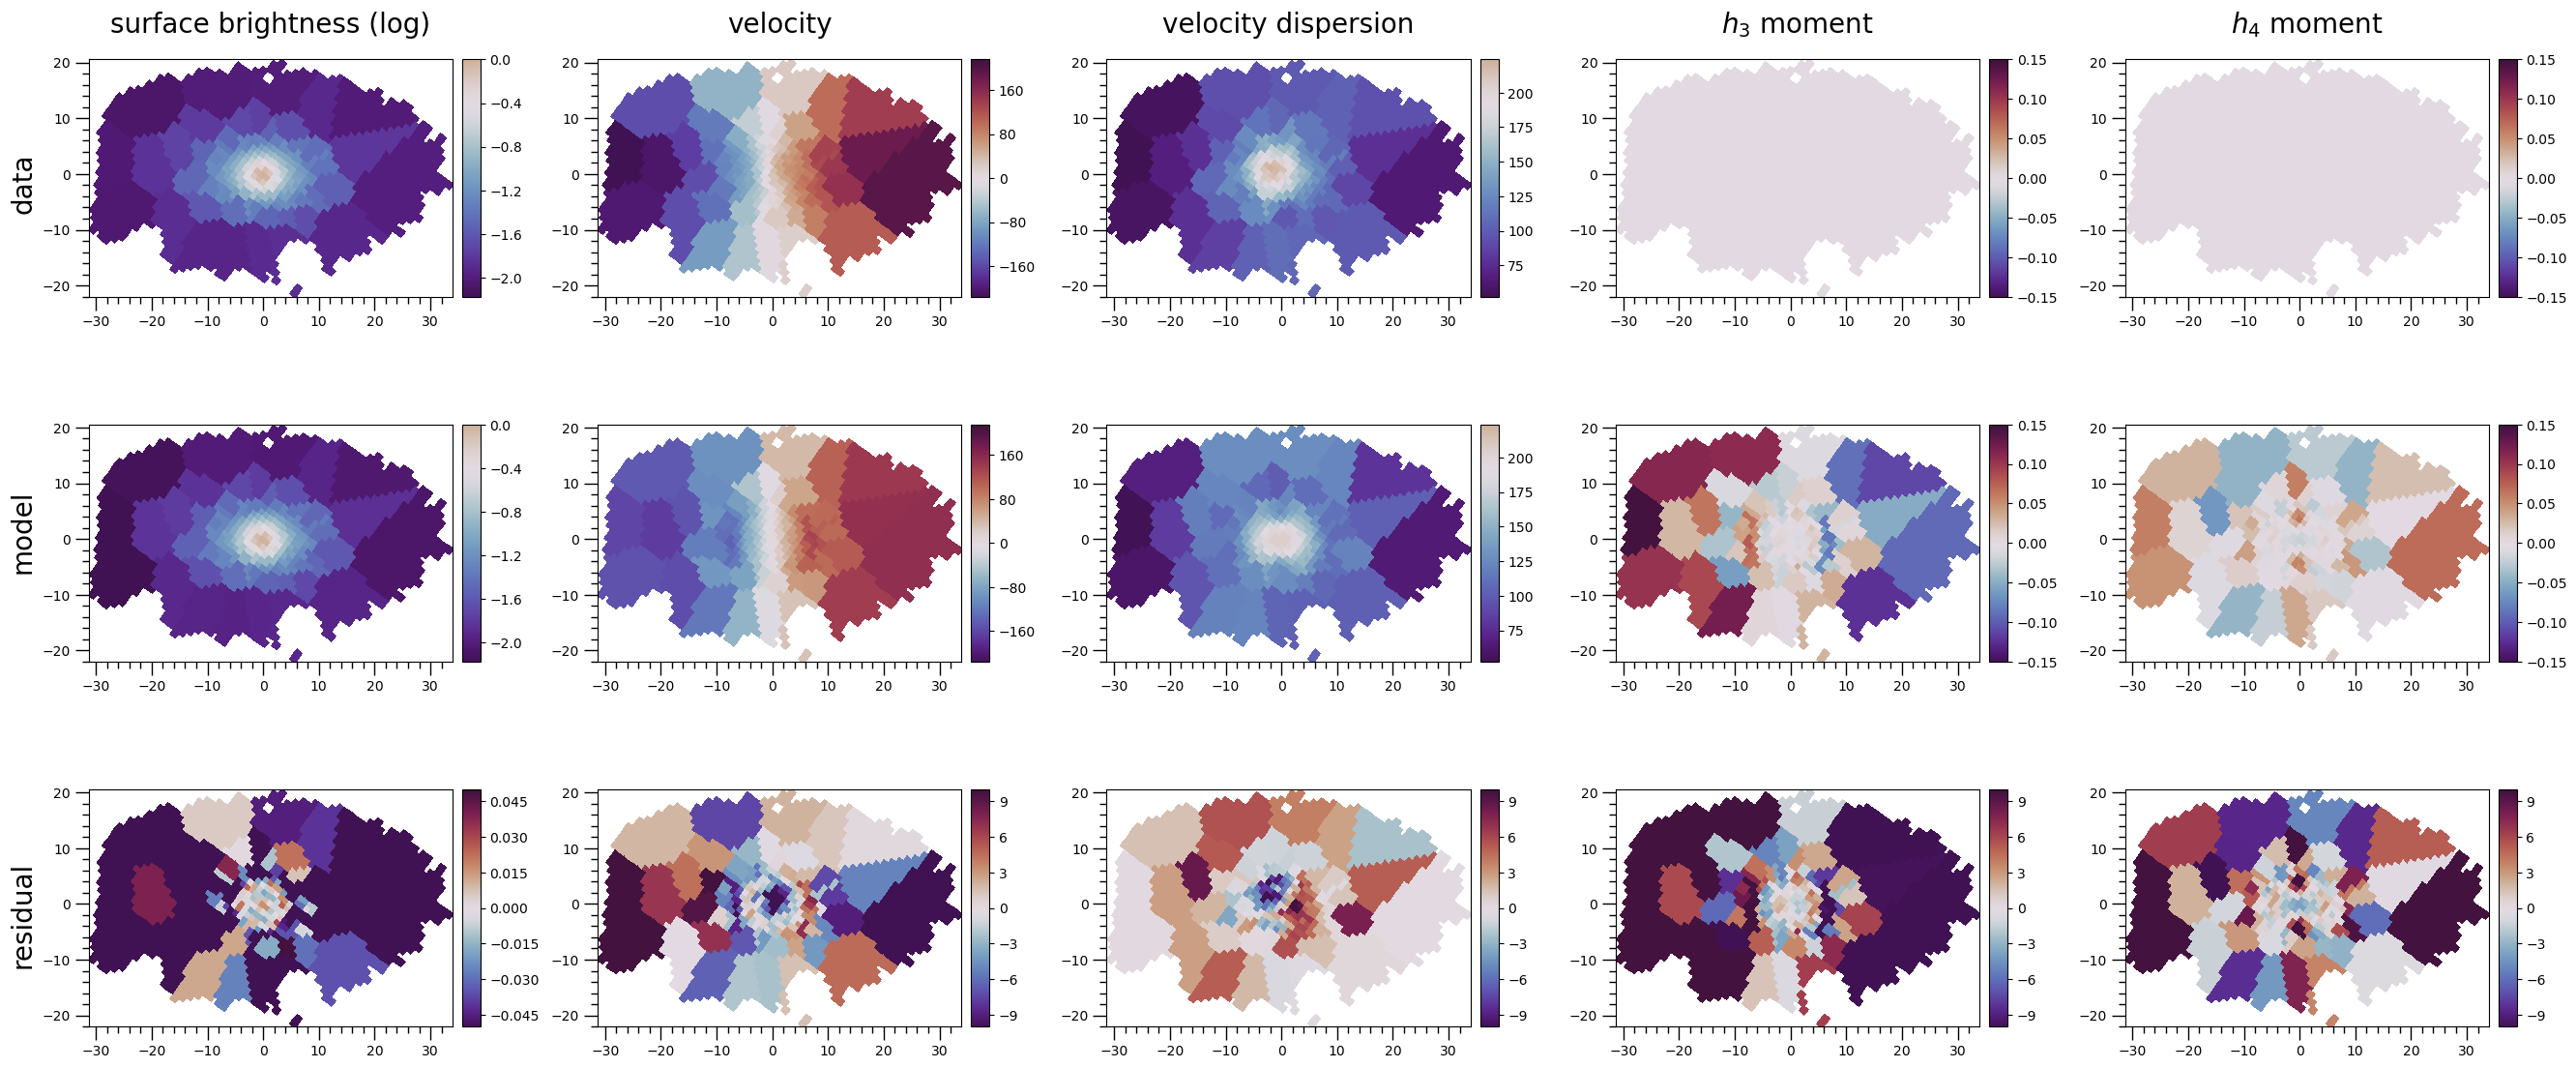

In [20]:
plotter = dyn.plotter.Plotter(config=c)
figure = plotter.plot_kinematic_maps(model)

The top row shows the data, the middle row shows the model, and the bottom row shows the residuals. The columns, from left to right, are the stellar surface density, the mean velocity $V$, the velocity dispersion $\sigma$, and the $h_3$ and $h_4$ moments. In the figure, we can see that:

- the model and data surface densities are very similar
- the sense of rotation of the $V$ map is reproduced well, even though the amplitude is lower than observed
- the $\sigma$, $h_3$ and $h_4$ maps are less well reproduced

While the fit is certainly not perfect, it is reassuring to see that some features are already reproduced well. To improve the fit, we will have to explore the parameter space more fully. See the following tutorial "Model Iterations and Plots" (`3_model_iterations_and_plots.ipynb`) for more details.

## Exercise

Manually adjust a model parameter, run this new model adding it to the all models table, inspect the new table, and plot the new model's kinematic maps:

1. Adjust a model parameter, e.g. change the black hole mass from 5.0 to 5.2 (in the configuration file: `system_components -> bh -> parameters -> m -> value`).
2. Read the new configuration file and look at the existing all models table.

In [21]:
c = dyn.config_reader.Configuration(fname, reset_logging=True, reset_existing_output=False)
c.all_models.table

[INFO] 19:43:07 - dynamite.config_reader.Configuration - Config file NGC6278_config_single.yaml read.
[INFO] 19:43:07 - dynamite.config_reader.Configuration - io_settings...
[INFO] 19:43:07 - dynamite.config_reader.Configuration - Output directory tree: NGC6278_output/.
[INFO] 19:43:07 - dynamite.config_reader.Configuration - system_attributes...
[INFO] 19:43:07 - dynamite.config_reader.Configuration - model_components...
[INFO] 19:43:07 - dynamite.config_reader.Configuration - system_parameters...
[INFO] 19:43:07 - dynamite.config_reader.Configuration - orblib_settings...
[INFO] 19:43:07 - dynamite.config_reader.Configuration - weight_solver_settings...
[INFO] 19:43:07 - dynamite.config_reader.Configuration - Will attempt to recover partially run models.
[INFO] 19:43:07 - dynamite.config_reader.Configuration - parameter_space_settings...
[INFO] 19:43:07 - dynamite.config_reader.Configuration - multiprocessing_settings...
[INFO] 19:43:07 - dynamite.config_reader.Configuration - ... usi

m-bh,a-bh,c-dh,f-dh,q-stars,p-stars,u-stars,ml,chi2,kinchi2,kinmapchi2,time_modified,orblib_done,weights_done,all_done,which_iter,directory
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str256,bool,bool,bool,int64,str256
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,5.0,33649.39086884704,15917.066860828405,21314.247848107774,2023-10-26T16:29:56.000,True,True,True,0,orblib_000_000/ml05.00/
100000.0,0.001,8.0,3.1622776601683795,0.54,0.99,0.9999,5.0,30991.11762762379,17598.730851933888,22815.05093199939,2023-10-26T16:29:56.000,True,True,True,1,orblib_001_000/ml05.00/
100000.0,0.001,8.0,31.622776601683793,0.54,0.99,0.9999,5.0,40173.175744770124,16959.42790658713,22206.509342121193,2023-10-26T16:29:56.000,True,True,True,1,orblib_001_001/ml05.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,1.0,497022.221964989,362170.4757700949,189457.78696958243,2023-10-26T16:29:59.000,True,True,True,1,orblib_000_000/ml01.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,9.0,54888.860024039765,36551.18477693207,75141.63217246106,2023-10-26T16:29:59.000,True,True,True,1,orblib_000_000/ml09.00/
100000.0,0.001,8.0,5.623413251903491,0.54,0.99,0.9999,5.0,36730.03922229585,16672.12206429719,20550.53558278929,2023-10-26T16:31:02.000,True,True,True,2,orblib_002_000/ml05.00/
100000.0,0.001,8.0,17.78279410038923,0.54,0.99,0.9999,5.0,52679.2856566222,16544.940123191423,21818.352798117987,2023-10-26T16:31:02.000,True,True,True,2,orblib_002_001/ml05.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,3.0,77417.30767015449,53526.44612487139,48837.247282250304,2023-10-26T16:31:05.000,True,True,True,2,orblib_000_000/ml03.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,7.0,35168.23021192741,18463.68353309457,36806.02968568541,2023-10-26T16:31:05.000,True,True,True,2,orblib_000_000/ml07.00/


3. Inspect the new parameter values given in the configuration file.

In [22]:
c.parspace.get_parset()

m-bh,a-bh,c-dh,f-dh,q-stars,p-stars,u-stars,ml
float64,float64,float64,float64,float64,float64,float64,float64
158489.3192461114,0.001,8.0,10.0,0.54,0.99,0.9999,5.0


4. Run the new model defined by this new parameter set and inspect the new all models table. Did the chi-squared improve?

In [23]:
_ = dyn.model_iterator.ModelIterator(config=c)
c.all_models.table

[INFO] 19:43:07 - dynamite.model_iterator.ModelIterator - SpecificModels: iteration 5
[INFO] 19:43:07 - dynamite.parameter_space.SpecificModels - Found ONE individual model.
[INFO] 19:43:07 - dynamite.parameter_space.SpecificModels - SpecificModels added 0 new model(s) out of 1
[INFO] 19:43:07 - dynamite.model_iterator.ModelIterator - Stopping at iteration 6


m-bh,a-bh,c-dh,f-dh,q-stars,p-stars,u-stars,ml,chi2,kinchi2,kinmapchi2,time_modified,orblib_done,weights_done,all_done,which_iter,directory
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str256,bool,bool,bool,int64,str256
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,5.0,33649.39086884704,15917.066860828405,21314.247848107774,2023-10-26T16:29:56.000,True,True,True,0,orblib_000_000/ml05.00/
100000.0,0.001,8.0,3.1622776601683795,0.54,0.99,0.9999,5.0,30991.11762762379,17598.730851933888,22815.05093199939,2023-10-26T16:29:56.000,True,True,True,1,orblib_001_000/ml05.00/
100000.0,0.001,8.0,31.622776601683793,0.54,0.99,0.9999,5.0,40173.175744770124,16959.42790658713,22206.509342121193,2023-10-26T16:29:56.000,True,True,True,1,orblib_001_001/ml05.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,1.0,497022.221964989,362170.4757700949,189457.78696958243,2023-10-26T16:29:59.000,True,True,True,1,orblib_000_000/ml01.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,9.0,54888.860024039765,36551.18477693207,75141.63217246106,2023-10-26T16:29:59.000,True,True,True,1,orblib_000_000/ml09.00/
100000.0,0.001,8.0,5.623413251903491,0.54,0.99,0.9999,5.0,36730.03922229585,16672.12206429719,20550.53558278929,2023-10-26T16:31:02.000,True,True,True,2,orblib_002_000/ml05.00/
100000.0,0.001,8.0,17.78279410038923,0.54,0.99,0.9999,5.0,52679.2856566222,16544.940123191423,21818.352798117987,2023-10-26T16:31:02.000,True,True,True,2,orblib_002_001/ml05.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,3.0,77417.30767015449,53526.44612487139,48837.247282250304,2023-10-26T16:31:05.000,True,True,True,2,orblib_000_000/ml03.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,7.0,35168.23021192741,18463.68353309457,36806.02968568541,2023-10-26T16:31:05.000,True,True,True,2,orblib_000_000/ml07.00/


5. Plot the new model's kinematic maps (the new model is in the last row of the table).

[INFO] 19:43:07 - dynamite.plotter.Plotter - Plotting kinematic maps for kin_set no 0: califa
[INFO] 19:43:07 - dynamite.analysis.Analysis - Getting model projected masses and losvds.
[INFO] 19:43:07 - dynamite.weight_solvers.LegacyWeightSolver - Using WeightSolver: LegacyWeightSolver
[INFO] 19:43:07 - dynamite.weight_solvers.LegacyWeightSolver - Reading NNLS solution from existing output.
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
[INFO] 19:43:14 - dynamite.plotter.Plotter - Kinematic map written to NGC6278_output/plots/kinematic_map_califa.png.


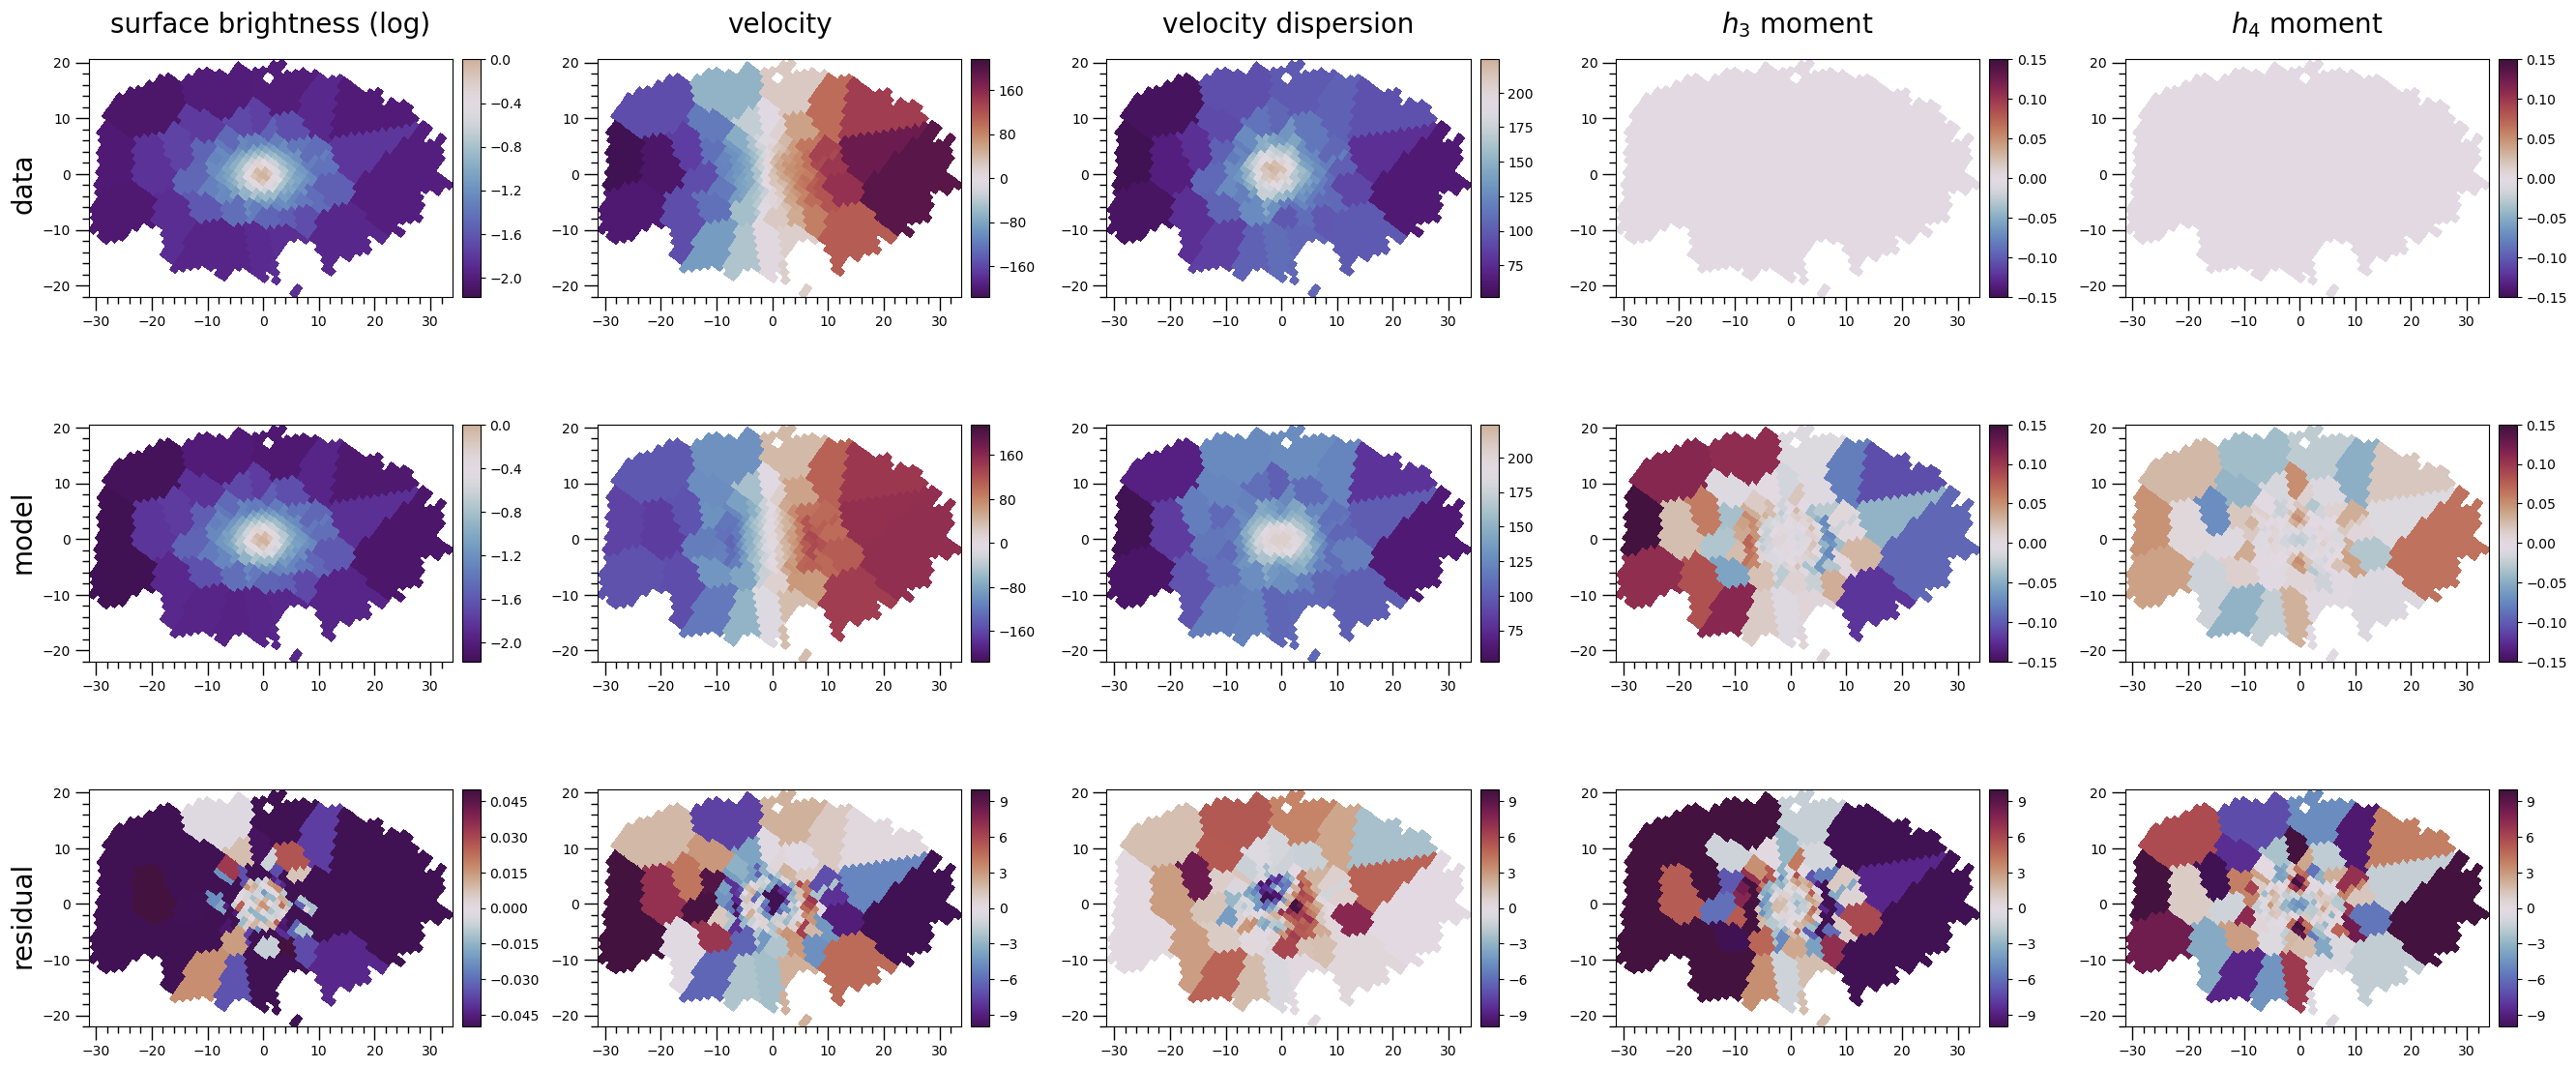

In [24]:
model = c.all_models.get_model_from_row(-1)
plotter = dyn.plotter.Plotter(config=c)
figure = plotter.plot_kinematic_maps(model)

Experiment some more with adding new models to the all models table...